In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import cv2
import os
from sklearn.model_selection import train_test_split
import numpy as np

# Define the paths to your stone and normal image directories
stone_dir = "/content/drive/MyDrive/Dataset/Train/Kidney_stone/"
normal_dir = "/content/drive/MyDrive/Dataset/Train/Normal/"

# Function to load and preprocess images
def load_and_preprocess_images(image_dir, label):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Read the image
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Assuming images are grayscale

            # Normalize pixel values to be between 0 and 1
            image = image / 255.0

            # Resize the images to a standard size (e.g., 128x128)
            image = cv2.resize(image, (128, 128))

            images.append(image)
            labels.append(label)

    return images, labels

# Load and preprocess stone images
stone_images, stone_labels = load_and_preprocess_images(stone_dir, label=1)

# Load and preprocess normal images
normal_images, normal_labels = load_and_preprocess_images(normal_dir, label=0)

# Combine stone and normal data
X = stone_images + normal_images
y = stone_labels + normal_labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the lists to NumPy arrays for compatibility with machine learning libraries
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


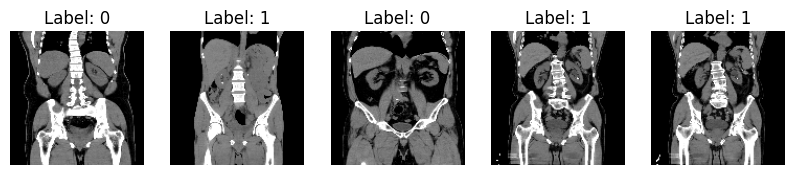

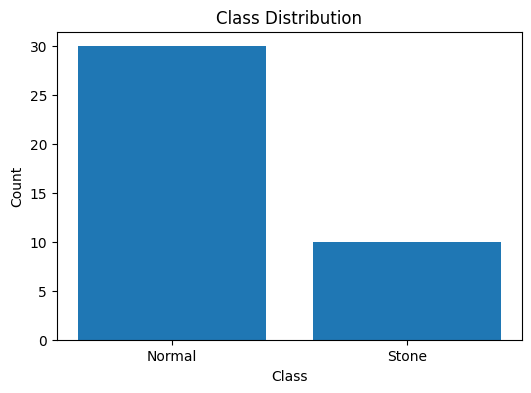

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Display a few sample images
sample_images = X_train[:5]  # Adjust the number of samples as needed
fig, axes = plt.subplots(1, len(sample_images), figsize=(10, 3))

for i, image in enumerate(sample_images):
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Label: {y_train[i]}")

plt.show()

# Plot class distribution
plt.figure(figsize=(6, 4))
plt.bar(['Normal', 'Stone'], [np.sum(y_train == 0), np.sum(y_train == 1)])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


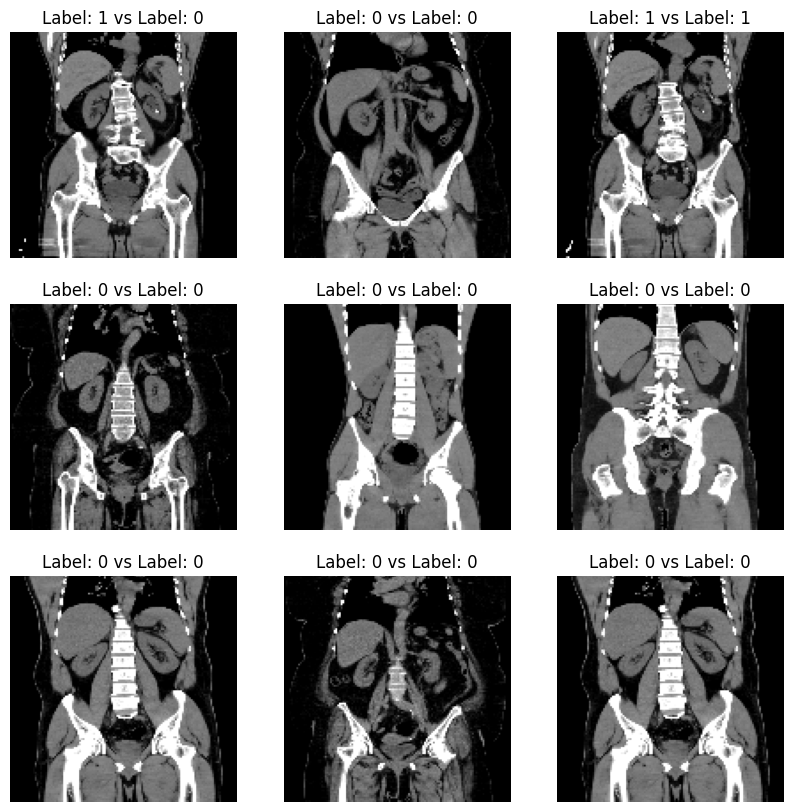

In [9]:
# Pairwise image comparisons
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        idx1, idx2 = np.random.choice(len(X_train), 2, replace=False)
        axes[i, j].imshow(X_train[idx1], cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f"Label: {y_train[idx1]} vs Label: {y_train[idx2]}")
plt.show()


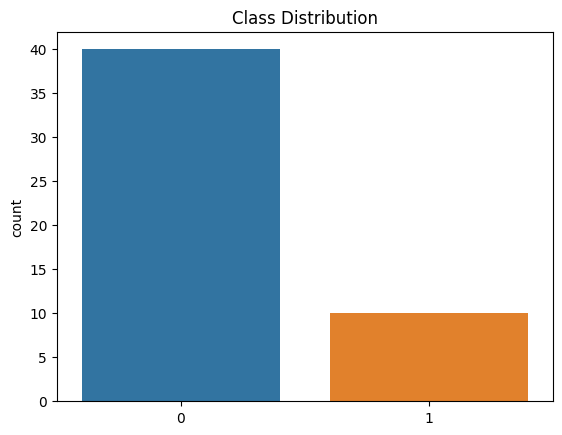

In [15]:
import seaborn as sns

# Assuming 'y' is your labels
sns.countplot(x=y)
plt.title('Class Distribution')
plt.show()


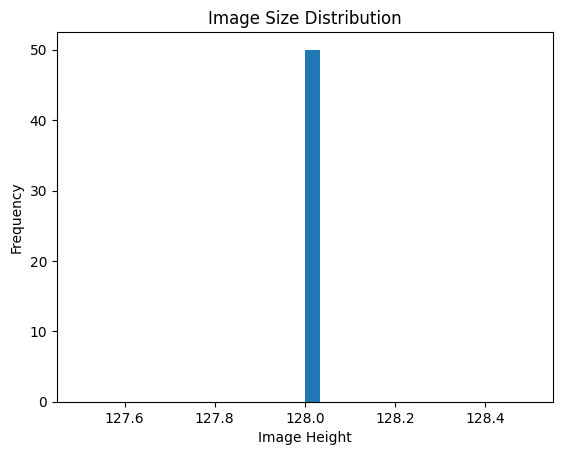

In [17]:
image_sizes = np.array([img.shape[0] for img in X])  # Assuming X is your dataset
plt.hist(image_sizes, bins=30)
plt.title('Image Size Distribution')
plt.xlabel('Image Height')
plt.ylabel('Frequency')
plt.show()


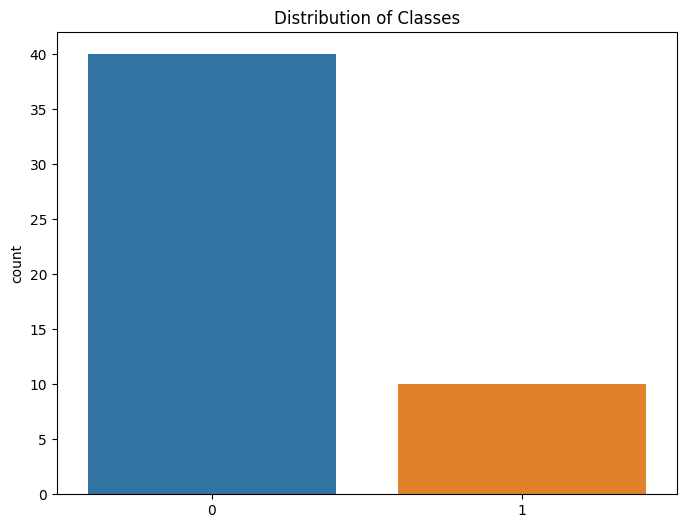

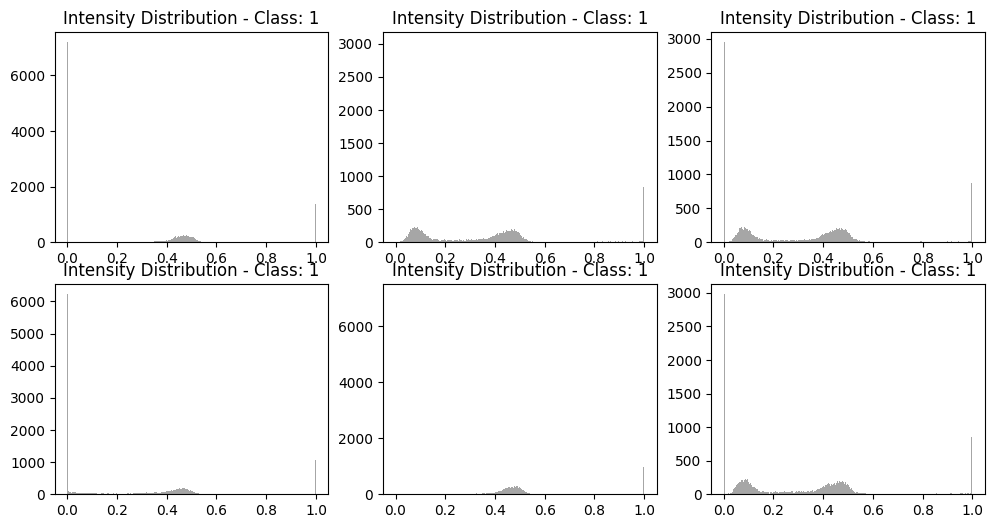

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/

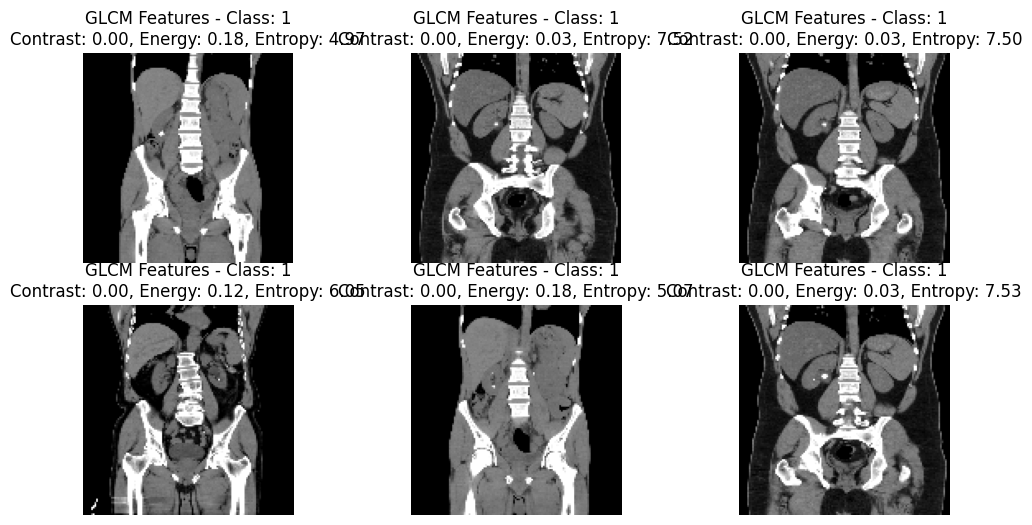

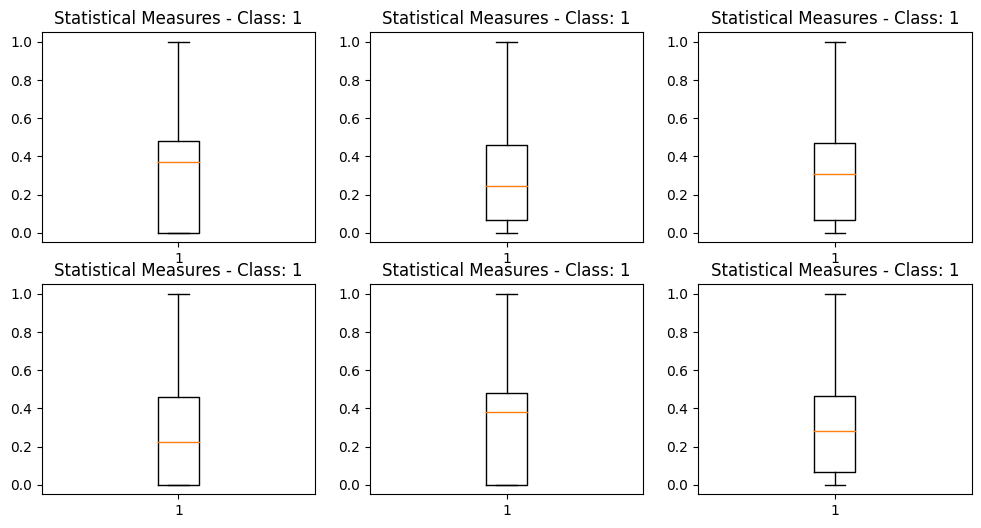

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from skimage import exposure
from skimage.feature import greycomatrix
from skimage.measure import shannon_entropy

# Define paths to directories containing images
stone_dir = "/content/drive/MyDrive/Dataset/Train/Kidney_stone/"
normal_dir = "/content/drive/MyDrive/Dataset/Train/Normal/"

# Function to load and preprocess images
def load_and_preprocess_images(image_dir, label):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Read the image
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Assuming images are grayscale

            # Normalize pixel values to be between 0 and 1
            image = image / 255.0

            # Resize the images to a standard size (e.g., 128x128)
            image = cv2.resize(image, (128, 128))

            images.append(image)  # Don't flatten for texture analysis
            labels.append(label)

    return images, labels

# Load and preprocess stone images
stone_images, _ = load_and_preprocess_images(stone_dir, label=1)

# Load and preprocess normal images
normal_images, _ = load_and_preprocess_images(normal_dir, label=0)

# Combine stone and normal data
X = stone_images + normal_images
y = [1] * len(stone_images) + [0] * len(normal_images)

# Convert the lists to NumPy arrays for compatibility with machine learning libraries
X = np.array(X)
y = np.array(y)

# Data distribution visualization
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Distribution of Classes')
plt.show()

# Visualize intensity distribution
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.hist(X[i].ravel(), bins=256, color='gray', alpha=0.7)
    plt.title(f"Intensity Distribution - Class: {y[i]}")
plt.show()

# Texture analysis using Grey Level Co-occurrence Matrix (GLCM)
def calculate_glcm_features(image):
    # Ensure the image is in the correct data type (unsigned integer)
    image = (image * 255).astype(np.uint8)

    glcm = greycomatrix(image, [1], [0], symmetric=True, normed=True)
    contrast = np.sum((glcm[:, :, 0, 0] * (np.arange(glcm.shape[0]) - np.arange(glcm.shape[1])) ** 2))
    energy = np.sum(glcm[:, :, 0, 0] ** 2)
    entropy = -np.sum(glcm[:, :, 0, 0] * np.log(glcm[:, :, 0, 0] + 1e-10))
    return contrast, energy, entropy

# Calculate and visualize texture features
plt.figure(figsize=(12, 6))
for i in range(6):
    contrast, energy, entropy = calculate_glcm_features(X[i])
    plt.subplot(2, 3, i + 1)
    plt.imshow(X[i], cmap='gray')
    plt.title(f"GLCM Features - Class: {y[i]}\nContrast: {contrast:.2f}, Energy: {energy:.2f}, Entropy: {entropy:.2f}")
    plt.axis('off')
plt.show()

# Statistical measures
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.boxplot(X[i].ravel())
    plt.title(f"Statistical Measures - Class: {y[i]}")
plt.show()


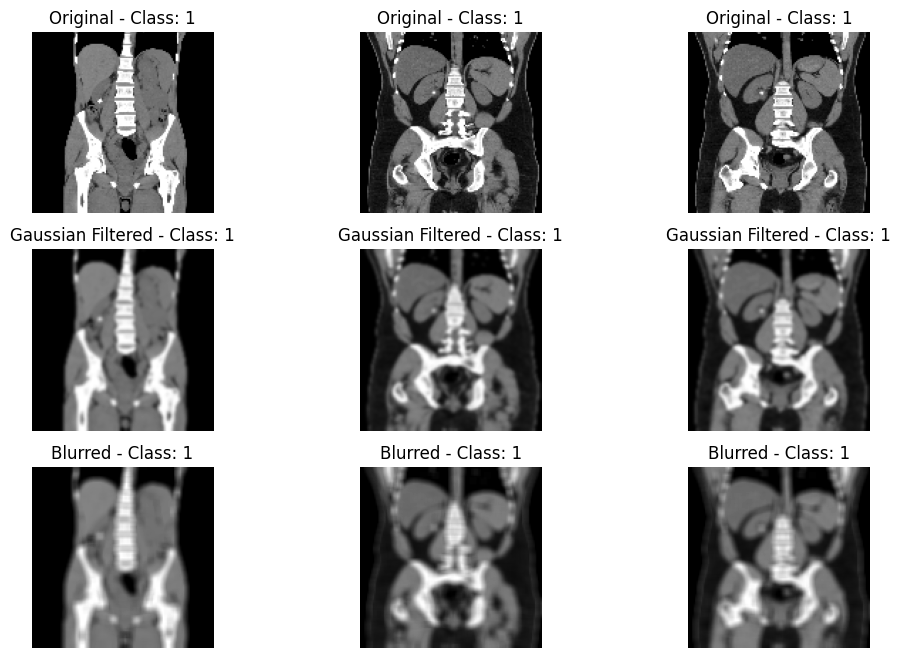

In [4]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from skimage import exposure
from skimage.feature import greycomatrix
from skimage.measure import shannon_entropy

# Define paths to directories containing images
stone_dir = "/content/drive/MyDrive/Dataset/Train/Kidney_stone/"
normal_dir = "/content/drive/MyDrive/Dataset/Train/Normal/"

# Function to load and preprocess images
def load_and_preprocess_images(image_dir, label):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Read the image
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Assuming images are grayscale

            # Normalize pixel values to be between 0 and 1
            image = image / 255.0

            # Resize the images to a standard size (e.g., 128x128)
            image = cv2.resize(image, (128, 128))

            images.append(image)  # Don't flatten for texture analysis
            labels.append(label)

    return images, labels

# Load and preprocess stone images
stone_images, _ = load_and_preprocess_images(stone_dir, label=1)

# Load and preprocess normal images
normal_images, _ = load_and_preprocess_images(normal_dir, label=0)

# Combine stone and normal data
X = stone_images + normal_images
y = [1] * len(stone_images) + [0] * len(normal_images)

# Convert the lists to NumPy arrays for compatibility with machine learning libraries
X = np.array(X)
y = np.array(y)

# Apply Gaussian filtering
gaussian_filtered_images = [cv2.GaussianBlur(img, (5, 5), 0) for img in X]

# Apply blurring
blurred_images = [cv2.blur(img, (5, 5)) for img in X]

# Visualize the original, Gaussian filtered, and blurred images
plt.figure(figsize=(12, 8))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X[i], cmap='gray')
    plt.title(f"Original - Class: {y[i]}")
    plt.axis('off')

    plt.subplot(3, 3, i + 4)
    plt.imshow(gaussian_filtered_images[i], cmap='gray')
    plt.title(f"Gaussian Filtered - Class: {y[i]}")
    plt.axis('off')

    plt.subplot(3, 3, i + 7)
    plt.imshow(blurred_images[i], cmap='gray')
    plt.title(f"Blurred - Class: {y[i]}")
    plt.axis('off')

plt.show()


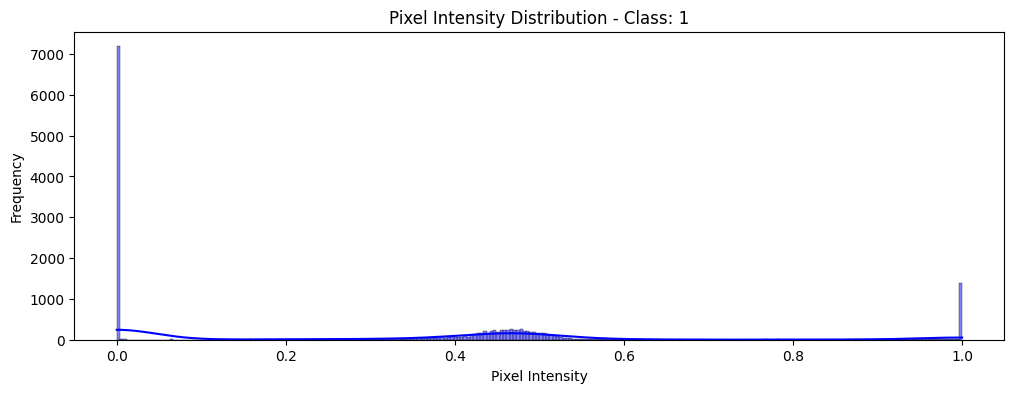

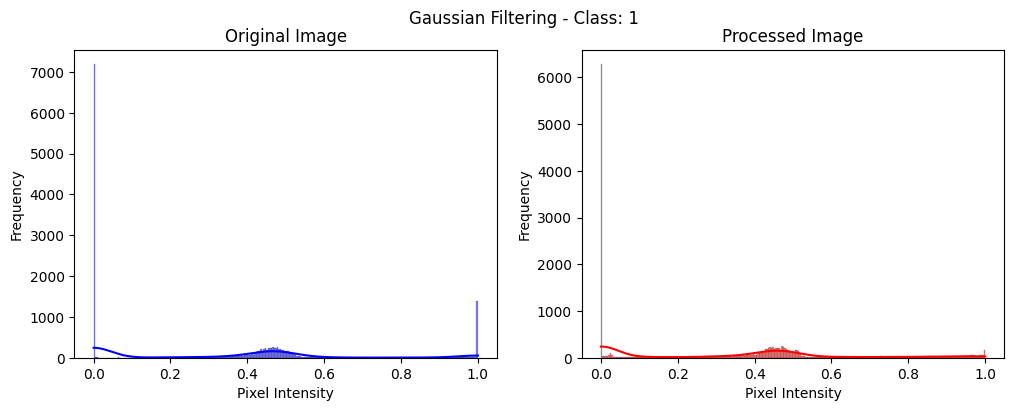

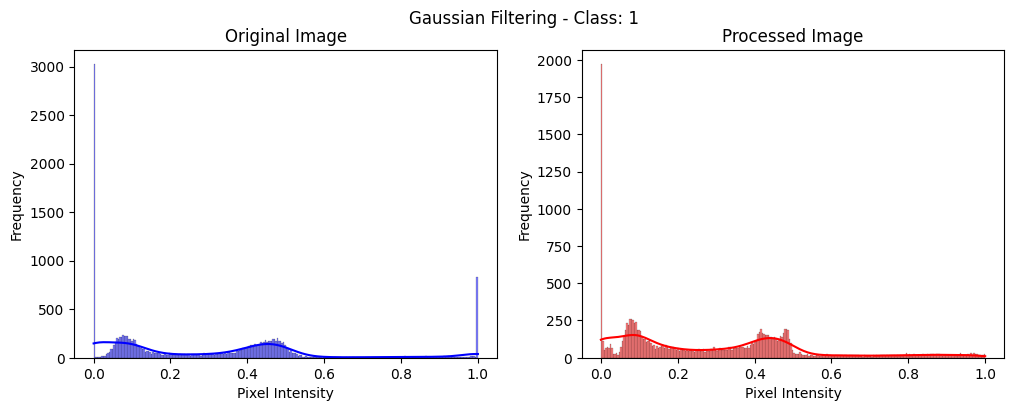

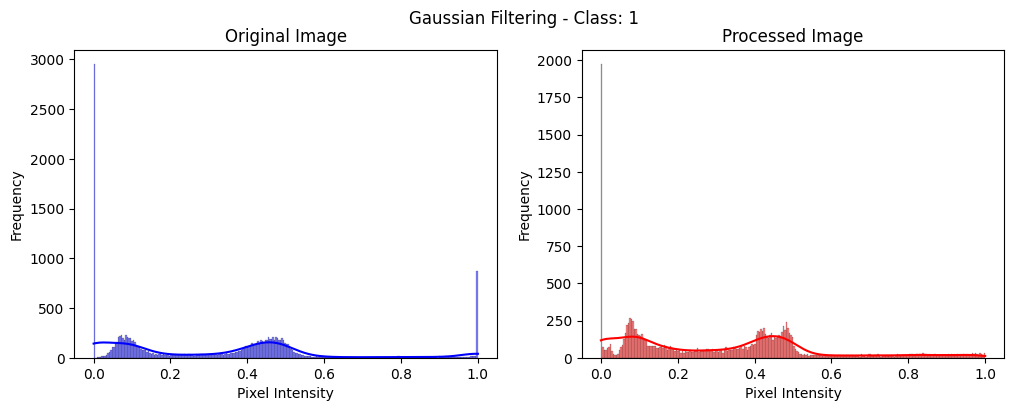

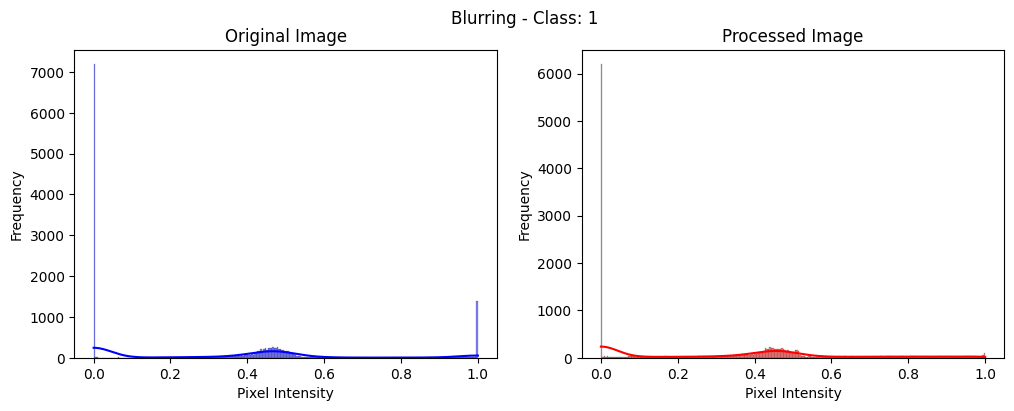

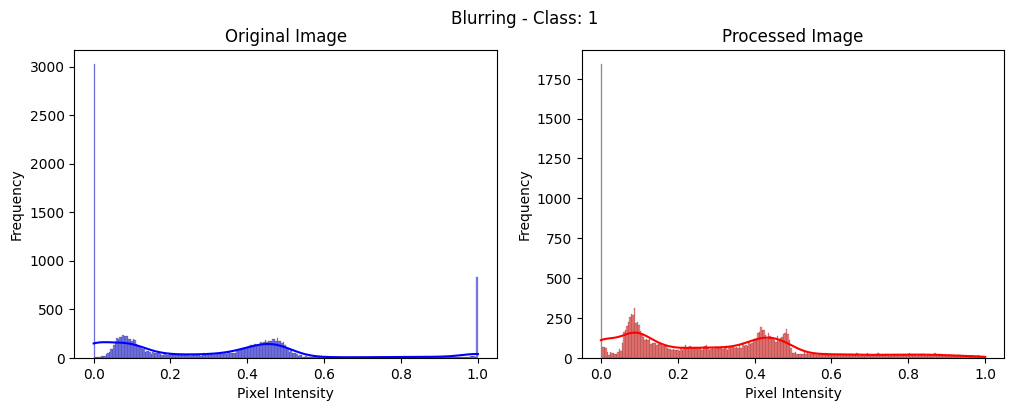

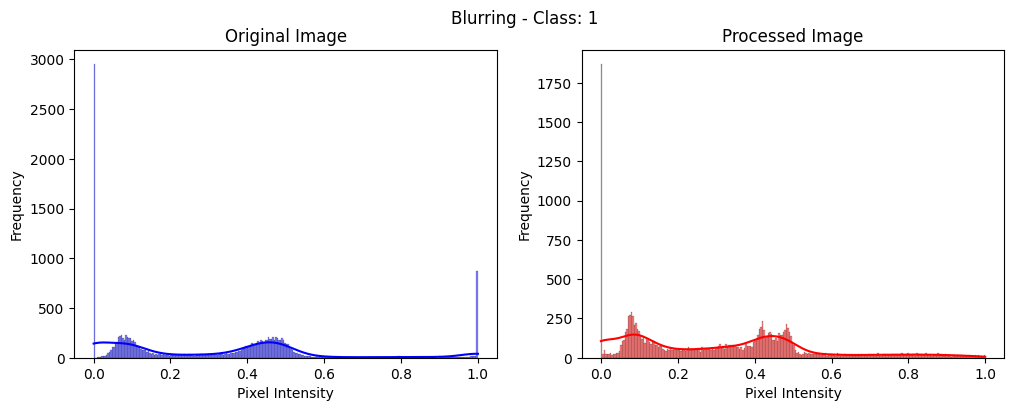

In [5]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from skimage import exposure
from skimage.feature import greycomatrix
from skimage.measure import shannon_entropy

# Define paths to directories containing images
stone_dir = "/content/drive/MyDrive/Dataset/Train/Kidney_stone/"
normal_dir = "/content/drive/MyDrive/Dataset/Train/Normal/"

# Function to load and preprocess images
def load_and_preprocess_images(image_dir, label):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Read the image
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Assuming images are grayscale

            # Normalize pixel values to be between 0 and 1
            image = image / 255.0

            # Resize the images to a standard size (e.g., 128x128)
            image = cv2.resize(image, (128, 128))

            images.append(image)  # Don't flatten for texture analysis
            labels.append(label)

    return images, labels

# Load and preprocess stone images
stone_images, _ = load_and_preprocess_images(stone_dir, label=1)

# Load and preprocess normal images
normal_images, _ = load_and_preprocess_images(normal_dir, label=0)

# Combine stone and normal data
X = stone_images + normal_images
y = [1] * len(stone_images) + [0] * len(normal_images)

# Convert the lists to NumPy arrays for compatibility with machine learning libraries
X = np.array(X)
y = np.array(y)

# Visualize pixel intensity distribution
plt.figure(figsize=(12, 4))
sns.histplot(X[0].ravel(), bins=256, color='blue', kde=True)
plt.title(f"Pixel Intensity Distribution - Class: {y[0]}")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

# Visualize histograms of original and processed images
def plot_histograms(original, processed, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(original.ravel(), bins=256, color='blue', kde=True)
    plt.title("Original Image")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.histplot(processed.ravel(), bins=256, color='red', kde=True)
    plt.title("Processed Image")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    plt.suptitle(title)
    plt.show()

# Apply Gaussian filtering and visualize histograms
for i in range(3):
    gaussian_filtered_img = cv2.GaussianBlur(X[i], (5, 5), 0)
    plot_histograms(X[i], gaussian_filtered_img, f"Gaussian Filtering - Class: {y[i]}")

# Apply blurring and visualize histograms
for i in range(3):
    blurred_img = cv2.blur(X[i], (5, 5))
    plot_histograms(X[i], blurred_img, f"Blurring - Class: {y[i]}")
